In [1]:

import os
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import syndat
import scipy.stats as stat
import matplotlib as mpl
#import syndat.plot as myplt
import sys


sammy_directory =  "/Users/noahwalton/Documents/GitHub/nuc_syndat/synthetic_data/Ta181"
#'/Users/nwx/Documents/GitHub/nuc_syndat/synthetic_data/Ta181' #os.path.realpath('./synthetic_data/Ta181')




In [2]:
%matplotlib notebook

In [3]:
# redux parms ---  experimentally unique values

# =============================================================================
# # constants and uncertainties
# =============================================================================
n = .12 # need to pull this from the endf evaluation
trig_o = 9760770 # number of linac pulses for open 
trig_i = 18479997 
flux_mag = 1e5 # what is a reasonable flux magnitude??
detector_efficiency = 1
tof_dist = 35.185 # m   !!! not the proper tof_distance, but I need the erange to match up
t0 = 3.326

# assuming 1% uncertainty of these values
m1 = 1; dm1 = m1*0.016
m2 = 1; dm2 = m2*0.008
m3 = 1; dm3 = m3*0.018
m4 = 1; dm4 = m4*0.005
alpha = [m1,m2,m3,m4]; d_alpha = [dm1,dm2,dm3,dm4]

a = 582.8061256946647; da = 1.14174241e+03
b = 0.0515158865500879; db = 2.18755273e-05
# a,b COV 1.42405866e-01

# sample in
k_i = 0.563; dk_i = k_i*0.0427
b0_i = 10.0; db0_i = b0_i*0.01
# sample out
K_o = 1.471; dK_o = K_o*0.0379
B0_o = 13.4; dB0_o = B0_o*0.01

In [4]:
# =============================================================================
# # open count rate 
# =============================================================================

# # estimate true underlying, raw, open count data with a wide gaussian flux
# cts_o_true = syndat.exp_effects.generate_open_counts(energy, flux_mag, 50, 100)

# or: import open count rate from RPI Ta-181 experiment:
C_o = pd.read_csv(os.path.join(sammy_directory,'rpi-open-ta181.csv'), sep=',') #pd.read_csv(os.path.join(sammy_directory,'ta181opencountrate.dat'), sep=',')
C_o['E'] = syndat.exp_effects.t_to_e((C_o.tof+t0)*1e-6, tof_dist, True) 

cts_o_true = C_o.counts
tof = C_o.tof  #!!! tof must be in microseconds to have the proper magnitude that Jesse normed to
energy = C_o.E

# get bin width vector from tof o
# bw = np.flipud(np.diff(np.flipud(tof)))
# bw = np.insert(bw,0,bw[0]) # assumes given leading tof edge
bw = C_o.bin_width*1e-6 # must we convert to microseconds

# background function - Jesse has normalized alread, tof mus be micro-seconds
def bkg_func(ti,a,b):
    return a*np.exp(ti*-b)
Bi = bkg_func(tof,a,b)


# =============================================================================
# 
# #plt.plot(C_o['tof'], C_o['co'])
# plt.plot(tof, ctr_o_true)
# plt.xlabel('tof'); plt.ylabel('countrate')
# plt.yscale('log'); plt.xscale('log')
# plt.show(); plt.close()
# =============================================================================

# syndat.sammy_interface.write_estruct_file(energy, "/Users/noahwalton/Library/Mobile Documents/com~apple~CloudDocs/Research Projects/Resonance Fitting/summer_2022/Ta181_sammy/estruct")


In [5]:
# plt.figure()
# plt.plot(tof,cts_o_true, label='counts')
# plt.plot(tof,cts_o_true/(bw*trig), label='cps')
# plt.yscale('log');plt.xscale('log')
# plt.legend()


In [6]:
#%% read sammy lst for experimentally corrected theoretical cross section

sam = syndat.sammy_interface.readlst(os.path.join(sammy_directory,'SAMMY.LST'))
# sam = pd.read_csv("/Users/noahwalton/research_local/resonance_fitting/summer_2022/ogsam.csv", sep=',', names=['E','exp_xs','exp_xs_unc','theo_xs','theo_xs_bayes','exp_trans','exp_trans_unc','theo_trans', 'theo_trans_bayes'])
# could test that energy structure lines up the same
# energy = sam['E'] 

T_theo = np.flipud(sam.theo_trans)

# plt.figure()
# plt.plot(tof,T_theo)
# plt.xscale('log'); plt.yscale('log')

In [7]:
#%%
# =============================================================================
# # generate noisy, raw, sample in count data with statistical unc from a true underlying transmission
# =============================================================================

# noisy_cts_i, noisy_cts_i_se, cts_i, cts_i_se = syndat.exp_effects.generate_raw_count_data(energy, T_theo, cts_o_true, bw, trig, k_i,K_o, Bi, b0_i,B0_o, alpha)

# calculate open count rates
# Cr, dCr = syndat.exp_effects.cts_to_ctr(cts_o_true, np.sqrt(cts_o_true), bw, trig) # cts_o/(bw*trig)
Cr = cts_o_true/(bw*trig_o)
partial = 1/(bw*trig_o) 
dCr = [np.sqrt((partial[i]**2)*np.sqrt(dc)**2) for i,dc in enumerate(cts_o_true)]

# calculate sample in count rate from theoretical transmission, bkg, m,k, and open count rate
[m1,m2,m3,m4] = alpha
cr = (T_theo*(m3*Cr - m4*K_o*Bi - B0_o) + m2*k_i*Bi + b0_i)/m1

#bw = np.array([6.4e-6]*len(energy))
#trig_i=trig_o
# calculate sample in counts, noise, and uncertainty
c = cr*bw*trig_i
c = np.where(c<0, 100, c) 
print("WARNING: artificially inflating sample in counts where background is > cts_out")
dc = np.sqrt(c)
nc = syndat.exp_effects.gaus_noise(c,dc) # will create some negative counts, force to zero
nc = np.where(nc<0, 1, nc) # replace negative counts with 0
dnc = np.sqrt(nc)



In [8]:
# calculated sample in count rate clean and noisey

cr = c/(bw*trig_i)
partial = 1/(bw*trig_i) 
dcr = [np.sqrt((partial[i]**2)*np.sqrt(c)**2) for i,c in enumerate(c)]
ncr = nc/(bw*trig_i)
partial = 1/(bw*trig_i) 
dncr = [np.sqrt((partial[i]**2)*np.sqrt(nc)**2) for i,nc in enumerate(nc)]


<IPython.core.display.Javascript object>


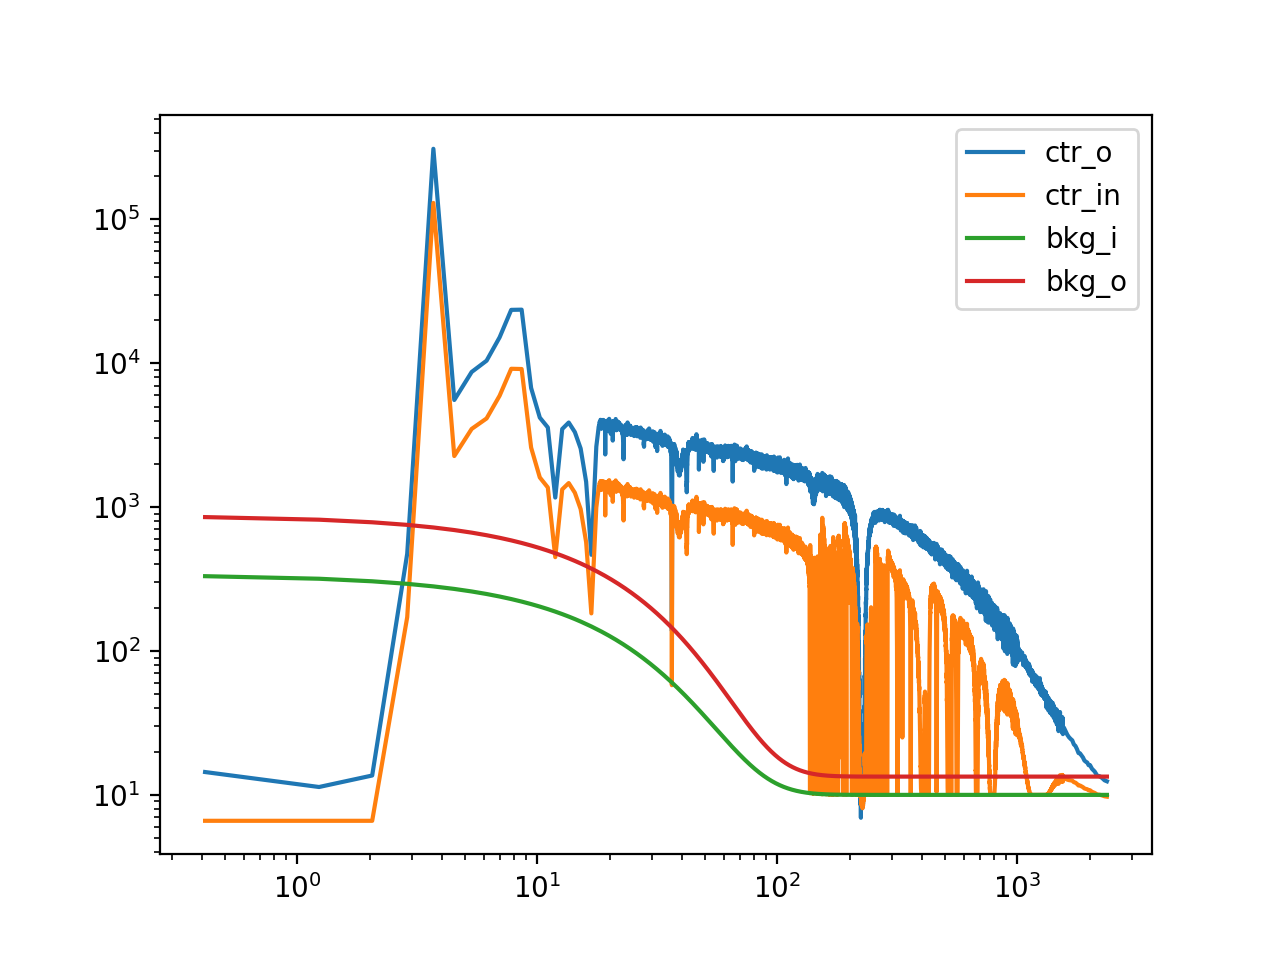

In [9]:
# # take a noisy measurement of raw open count data with uncertainty
# cts_o = cts_o_true # syndat.exp_effects.generate_open_counts(energy, flux_mag, 50, 100)
# cts_o_se = np.sqrt(cts_o) # statistical error from poisson counting stats
# noisy_cts_o = syndat.exp_effects.gaus_noise(cts_o, cts_o_se)
# noisy_cts_o_se = np.sqrt(noisy_cts_o)

plt.figure()
plt.plot(tof,Cr, label='ctr_o')
plt.plot(tof,cr, label='ctr_in')
# plt.plot(tof,cts_o_true, label='cts_o')
# plt.plot(tof,nc, label='cts_i')
plt.plot(tof, k_i*Bi + b0_i, label="bkg_i")
plt.plot(tof, K_o*Bi + B0_o, label="bkg_o")
# plt.plot(tof,T_theo, label=r'$T_{theo}$')
# plt.plot(tof,cts_o_se/cts_o*100, label='o')
# plt.plot(tof,noisy_cts_o_se/noisy_cts_i*100, label='in')
# plt.ylim([1e-3,3e5])
plt.legend()
plt.xscale('log'); plt.yscale('log')

<IPython.core.display.Javascript object>


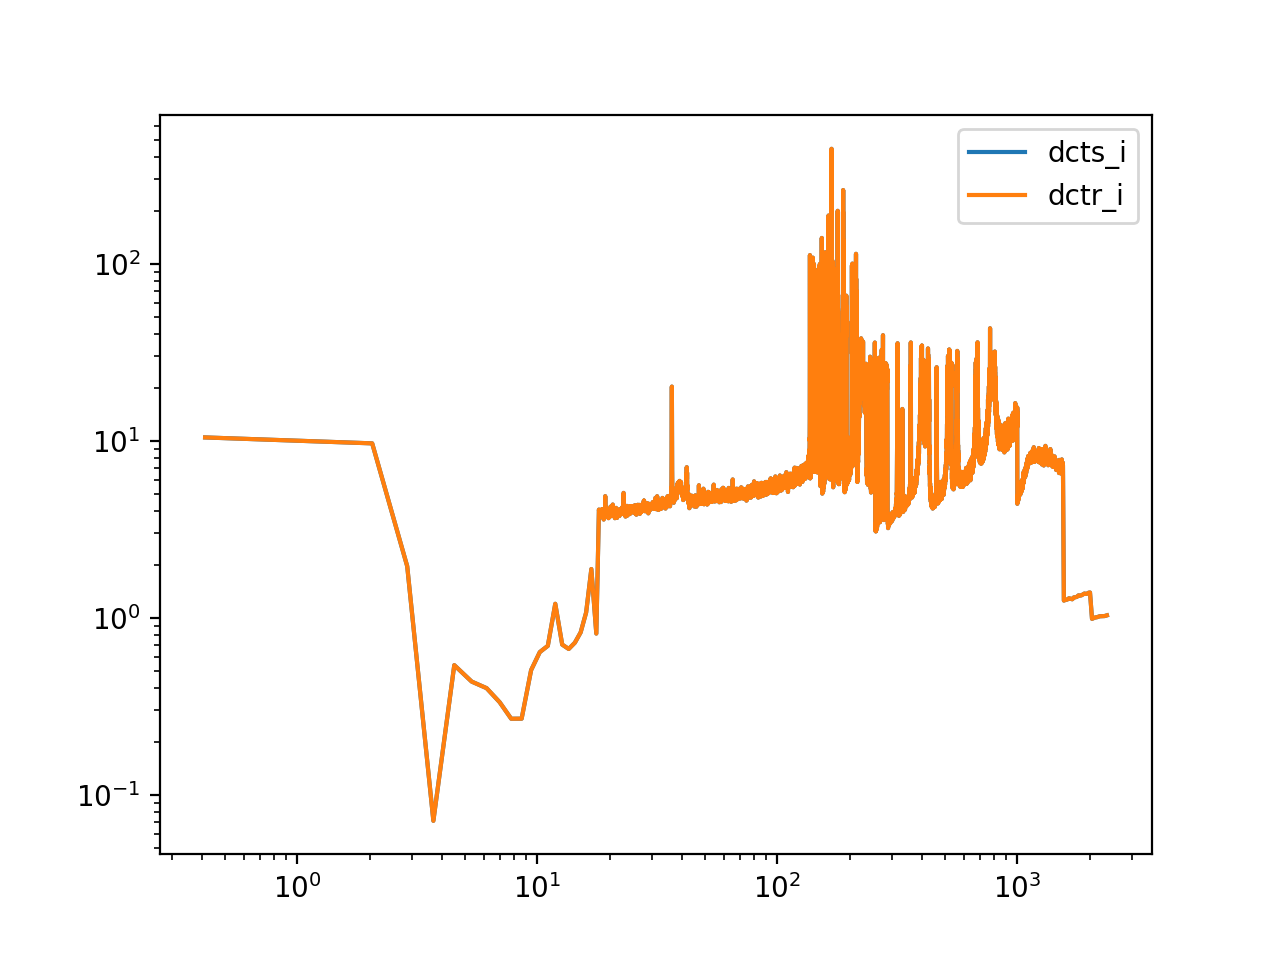

In [10]:
plt.figure()
# plt.plot(tof,np.sqrt(cts_o_true)/cts_o_true*100,label='dcts_o')
plt.plot(tof,dnc/nc*100,label='dcts_i')
# plt.plot(tof,dCr/Cr*100,label='dctr_o')
plt.plot(tof,dncr/ncr*100,label='dctr_i')
plt.legend()
plt.xscale('log'); plt.yscale('log')


In [11]:
#%% Plotting only

# this section is for plotting only, the next section does these calculations under the hood
# but we want out count rates for plotting

# ctr_o, ctr_o_se = syndat.exp_effects.cts_to_ctr(cts_o, cts_o_se, bw, trig) 
# ctr_i, ctr_i_se = syndat.exp_effects.cts_to_ctr(noisy_cts_i, noisy_cts_i_se, bw, trig)
# # Tn = syndat.exp_effects.transmission(ctr_i,ctr_o, Bi, k_i,K_o, b0_i,B0_o, alpha)

# #sum(C_o['dco'][0:-5]-ctr_o_se)

# #C_o
# plt.figure()
# plt.plot(tof,ctr_o_se/ctr_o)
# plt.plot(tof,ctr_i_se/ctr_i, label='in')
# plt.legend()
# plt.xscale('log'); plt.yscale('log')


In [12]:
# plt.figure()
# #plt.errorbar(tof,ctr_i, yerr=ctr_i_se,label='cr_i',color='cornflowerblue',ecolor='cornflowerblue',elinewidth=0.5,capsize=2, fmt='.', ms=1)
# #plt.errorbar(tof,ctr_o, yerr=ctr_o_se,color='orange',ecolor='orange',elinewidth=0.5,capsize=2, fmt='.', ms=1)
# plt.plot(tof,ctr_i_se/ctr_i*100, label='in')
# plt.plot(tof,ctr_o_se/ctr_o*100, label='out')
# # plt.plot(tof, ctr_i, lw=1, label='cr_s')
# # plt.plot(tof, ctr_o, lw=1, label='cr_o')
# # plt.plot(tof, T_theo, label='Theoretical T', c='k', alpha=0.5)

# plt.legend()
# #plt.ylim([1e-3,1e5])
# #plt.xlim([2e2, 2.5e2])
# plt.xscale('log'); plt.yscale('log')

# plt.title('Count Rate comparison with overlayed theoretical transmission')
# #plt.show(); plt.close()




In [17]:
#%% Reduce the noisy, raw count data

# compile systematic uncertainties
sys_unc = np.append([da,db,dk_i,dK_o,db0_i,dB0_o], d_alpha)
# %time
# #%%timeit
# # reduce raw, noisy count data with statistical uncertainties to transmission data with propagated uncertainty
Tn, dT, CovT = syndat.exp_effects.reduce_raw_count_data(tof, nc, cts_o_true, dnc, np.sqrt(cts_o_true), \
                                                        bw, trig_o, a,b, k_i,K_o, Bi, b0_i,B0_o, alpha, sys_unc)
# # calculate the correlation matrix
# CorT = np.corrcoef(CovT)


# =============================================================================
# make inputs the proper type
# =============================================================================
# dc = np.array(dnc)
# dC = np.array(np.sqrt(cts_o_true))

# # derivatives
# # denominator, numerator
# D = alpha[2]*cts_o_true - alpha[3]*K_o*Bi - B0_o
# N = alpha[0]*nc - alpha[1]*k_i*Bi - b0_i

# # statistical  --- !! Jesse does not have these alphas, but they are both 1 anyway
# dTi_dci = alpha[0]/D
# dTi_dCi = N*alpha[2]/D**2

# # systematic
# dTi_da = -(k*alpha[1]*D+K*alpha[3]*N)*np.exp(-b*tof) / (D**2)
# dTi_db = (k*alpha[1]*D)*Bi*tof / (D[i]**2)
# dTi_dk = -alpha[1]*Bi/D**2
# dTi_dK = N*alpha[3]*Bi/D**2
# dTi_db0 = -1/D
# dTi_dB0 = N/D**2
# dTi_dalpha = [c/D, -k*Bi/D, -C*N/D**2, K*Bi*N/D**2]
# dT_dsys = np.append([dTi_da, dTi_db, dTi_dk, dTi_dK, dTi_db0, dTi_dB0], dTi_dalpha)


# # construct statistical output covariance just diagonal so we can avoid matrix math
# dc_dC = np.append(dc,dC)
# ddc_ddC = np.append(dTi_dci,dTi_dCi)
# # Cov_stat = np.diag(dc_dC**2)
# # Jac_stat = np.vstack((dTi_dci,dTi_dCi))

# CovT_stat = np.diag(dc_dC**2*ddc_ddC**2)


# # construct systematic covariance and jacobian
# Cov_sys = np.diag(sys_unc**2)
# # =============================================================================
# #     Cov_sys = np.zeros([len(sys_unc),len(sys_unc)])
# #     for i in range(len(sys_unc)):
# #         for j in range(len(sys_unc)):
# #             if i == j:
# #                 Cov_sys[i,j] = sys_unc[i]
# # =============================================================================
# # print("WARNING: Need to update getCov function to take a/b covariances, currently it says cov = var*var")
# Cov_sys[0,1] = 1.42405866e-01 # sys_unc[0]*sys_unc[1]  
# Cov_sys[1,0] = 1.42405866e-01 #sys_unc[1]*sys_unc[0]        

# Jac_sys = np.zeros([len(sys_unc),len(tof)])
# for j in range(len(tof)):
#     Jac_sys[:,j] = dT_dsys(j)

# # calculate covariance of output
# # CovT_stat = Jac_stat.T @ Cov_stat @ Jac_stat
# CovT_sys = Jac_sys.T @ Cov_sys @ Jac_sys

# CovT = CovT_stat + CovT_sys

In [ ]:
#%%

plt.figure()
plt.matshow(CorT)
plt.colorbar()
plt.title('Correlation')

# plt.show(); plt.close()

In [ ]:

#plt.rcParams.update(plt.rcParamsDefault)




<IPython.core.display.Javascript object>


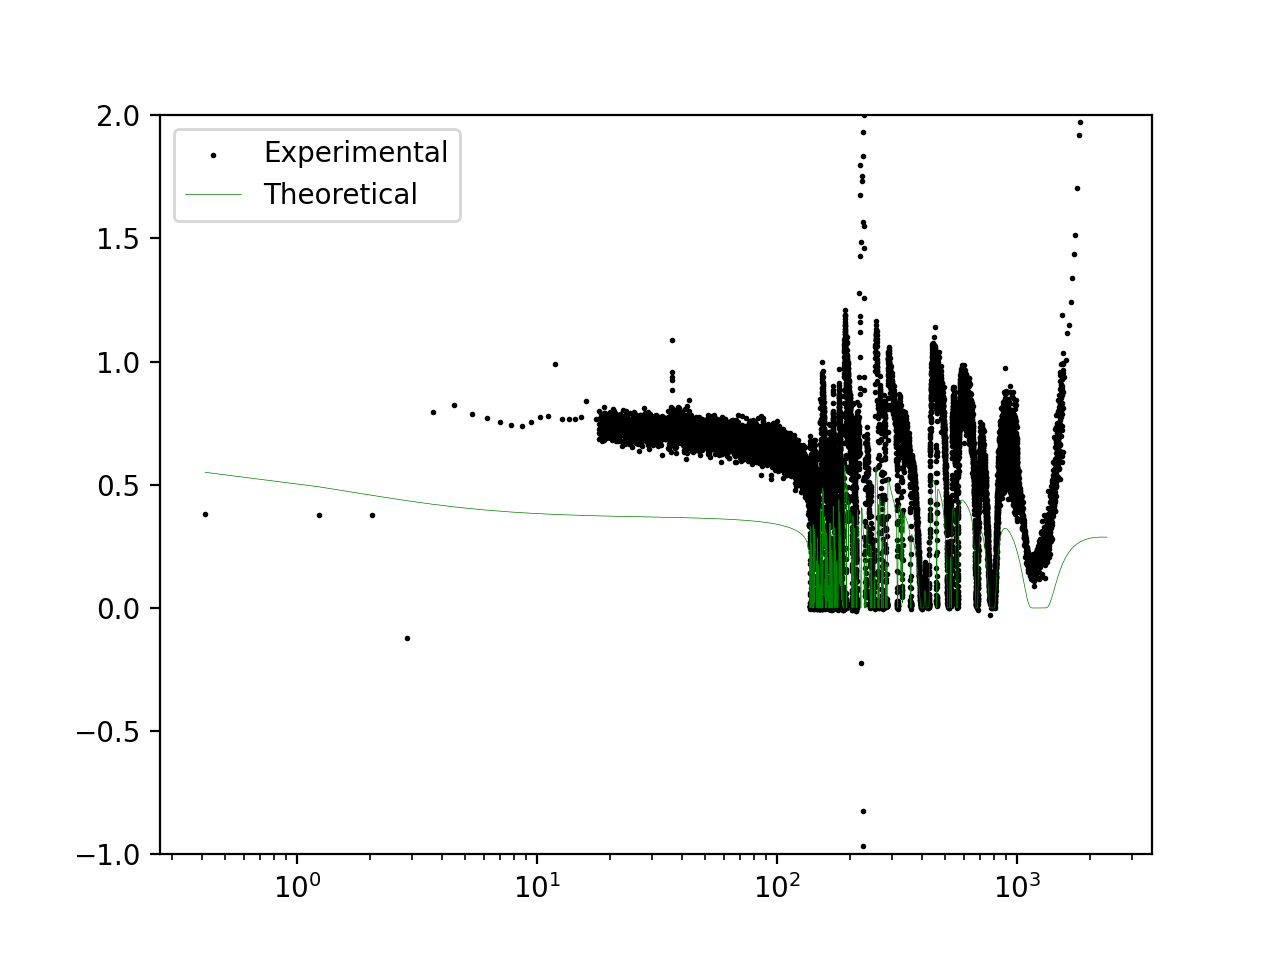

In [18]:
# syndat.plot.exp_theo(tof, Tn, dT, T_theo)
plt.figure()
# plt.errorbar(tof,Tn, yerr=dT,color='r',ecolor='k',elinewidth=1,capsize=2, fmt='.', ms=3)
plt.scatter(tof, Tn, label='Experimental', s=1, c='k')
plt.plot(tof, T_theo, label='Theoretical', c='g', lw=0.25)

plt.legend()
plt.ylim([-1,2])
#plt.xlim([1e2,1e3])
plt.xscale('log'); 

<IPython.core.display.Javascript object>


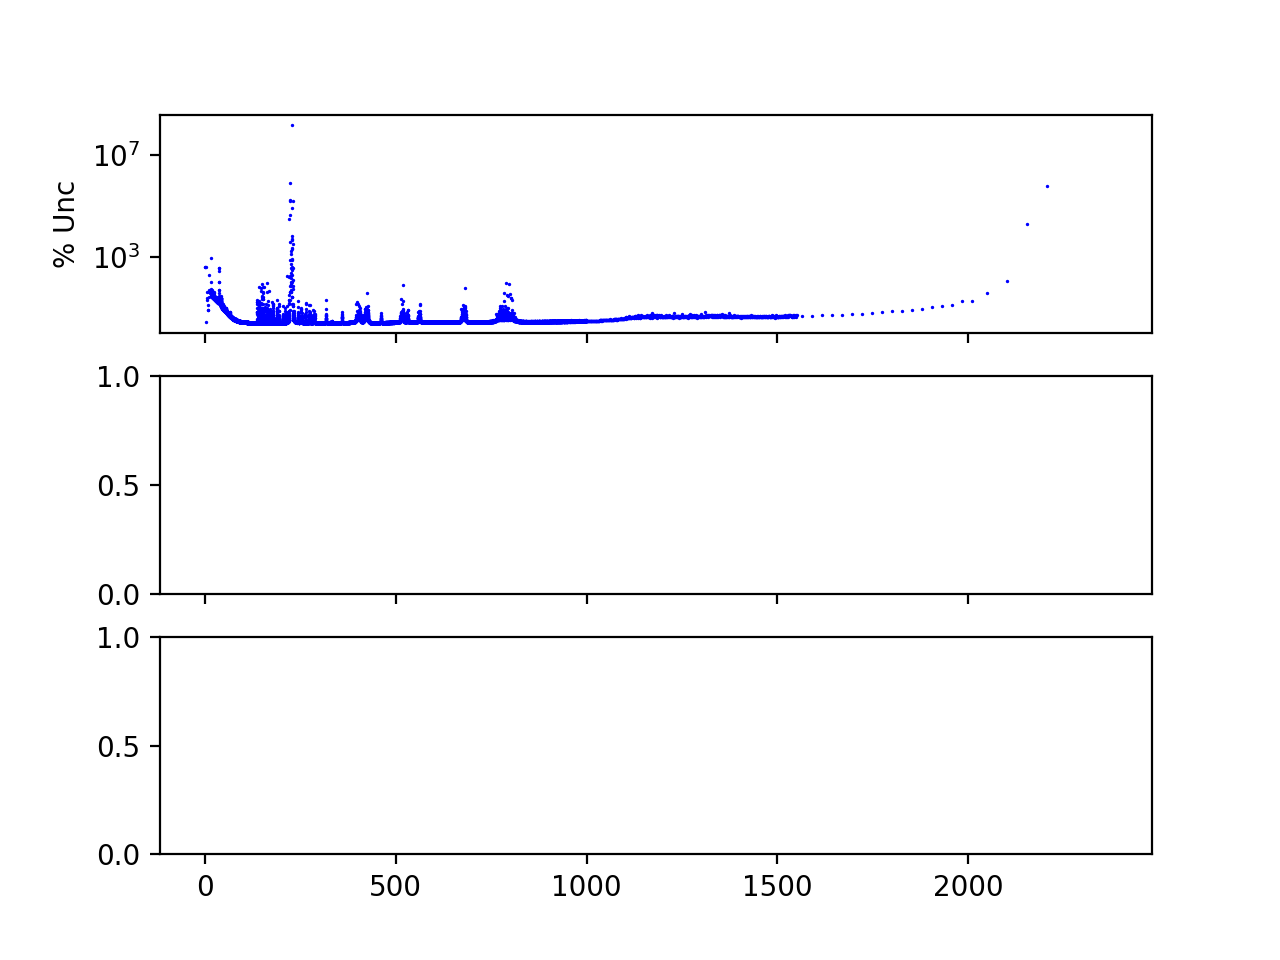

NameError: name 'ctr_o' is not defined

In [19]:
# syndat.plot.unc_noise(tof, dT, T_theo, Tn, ctr_o, ctr_i)

#fig, ax = plt.subplots(2,2, gridspec_kw={'height_ratios': [1, 1], 'width_ratios':[2,1]}) # , figsize=(12,5)
fig, (ax1, ax2, ax3) = plt.subplots(3, gridspec_kw={'height_ratios': [1, 1, 1]}, sharex=True) # , figsize=(12,5)
# plt.rcParams['figure.dpi'] = 500
# ax1 = ax[0,0]; ax2=ax[1,0]; ax3=ax[0,1]; ax4=ax[1,1]

ax1.scatter(tof, dT/Tn*100, lw=0.5, color='b', s=0.5, zorder=2)
#ax1.set_ylim([0,2])
ax1.set_yscale('log')
ax1.set_ylabel('% Unc'); #('$\sigma$')('$\delta$T')

ax2.plot(tof,ctr_o, lw= 0.5, c='orange', label=r'$ctr_{out}$')
ax2.plot(tof,ctr_i, lw= 0.5, c='cornflowerblue', label=r'$ctr_{in}$')
ax2.plot(tof,T_theo, lw= 0.5, c='g', label=r'$T_{theo}$')
ax2.set_yscale('log')
ax2.set_ylim([1e-5,3e5])
ax2.set_ylabel(r'$ctr_o$')
ax2.legend()
# =============================================================================
#     ax25 = plt.twinx(ax2)
#     ax25.plot(tof,T_theo, lw= 0.5, c='g', label=r'$T_{theo}$')
#     ax25.set_ylabel(r'$T_{theo}$')
#     ax25.set_yscale('log')
#     ax25.set_ylim([1e-3,1e1])
# =============================================================================

rel_se = (Tn-T_theo)/T_theo
ax3.scatter(tof, rel_se, s=0.5, c='b')
#ax3.set_ylim([0,1])
ax3.set_ylabel('Noise')
ax3.set_yscale('log')

#plt.xlim([1e2,2e3])

plt.xscale('log')
plt.xlabel('ToF (s)');
plt.suptitle('Uncertainty and Noise on Transmission')
plt.tight_layout()
#plt.show(); plt.close()

In [ ]:
plt.errorbar(tof,Tn, yerr=dT,color='k',ecolor='k',elinewidth=0.5,capsize=2, fmt='.', ms=1)
#plt.scatter(tof, Tn, label='Experimental', s=1, c='k')
plt.plot(tof, T_theo, label='Theoretical', c='g', lw=0.25)
#plt.legend()
plt.ylim([-.1,1.5])
# #plt.xlim([1e2,1e3])
plt.xscale('log')
#plt.yscale('log')
